# Rotini

**Background**

We prepare a Hall strip and then watch the free evolution of a quasi-1D interacting BEC under a gauge field with no external scalar potential in the rotating frame.

In [1]:
import sys, os
sys.path.append(os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt
from copy import copy, deepcopy
from tqdm.notebook import tqdm
from scipy.ndimage import rotate as rotate_image
from scipy.optimize import curve_fit
from PIL import Image
import time
import h5py
import pandas as pd
from condensate import Wavefunction, Environment, hbar
%matplotlib inline

def rotate_crop(array, viewx=200, viewy=350, angle=0):
    """ Rotate and crop a 2d array """
    s = np.shape(array)
    rotated = rotate_image(array, angle, reshape=False)
    cropped = rotated[(s[0]-viewy)//2 : (s[0]+viewy)//2 , (s[1]-viewx)//2 : (s[1]+viewx)//2 ]
    return cropped


def gauss(x,x0,a,s): return a*np.exp(- (x-x0) **2 / (2*s**2))

def satexp(t, tau,a): return (3.31+a*np.exp(-t/tau))

def rotate_crop(array, viewx=200, viewy=350, angle=0):
    """ Rotate and crop a 2d array """
    s = np.shape(array)
    rotated = rotate_image(array, angle, reshape=False)
    cropped = rotated[(s[0]-viewy)//2 : (s[0]+viewy)//2 , (s[1]-viewx)//2 : (s[1]+viewx)//2 ]
    return cropped

def find_angle(ncrop):
    xsize = len(ncrop)
    xx = np.linspace(-10, 10, xsize)
    yy = np.linspace(-10, 10, xsize)
    xx, yy = np.meshgrid(xx, yy)

    # Calculate the moment of inertia tensor
    Ixx = np.sum(ncrop*yy*yy)
    Iyy = np.sum(ncrop*xx*xx)
    Ixy = np.sum(ncrop*xx*yy)
    Iyx = Ixy
    I =np.array( [[Ixx, Ixy], [Iyx, Iyy]])
    evals, evecs = np.linalg.eig(I)
    iangle = (180*np.arctan(evecs[np.argmin(evals)][1]/evecs[np.argmin(evals)][0])/np.pi)
    return iangle


## Prepare groundstate

In [2]:
omega   = 2*np.pi*10
epsilon = 0.13
dt = 1e-5
fov = 350e-6
DIM=512

e = Environment(DIM=DIM, fov=fov, N=1e6)
e.harmonic_potential(omega=omega, epsilon=epsilon)


            Running condensate on 512x512 grid with:
            atom number: 1e+06 
            mass:        3.80e-26
        


In [3]:
groundstate = Wavefunction(e)
groundstate.initialize_Psi(width=100)
groundstate.relax(vmax=3e8, dt=dt, steps=4000)

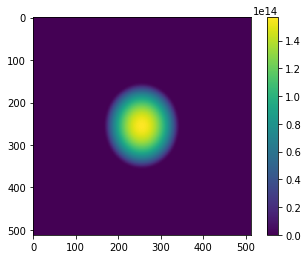

In [4]:
groundstate.show_density()

## Spin up

In [5]:
def rotation_freq_simple(timestep, whirrTime=30000, whirrMax=omega):
    tanh =  omega * 1.002 * np.tanh(3.46 * timestep / whirrTime)
    return np.min([whirrMax,tanh])

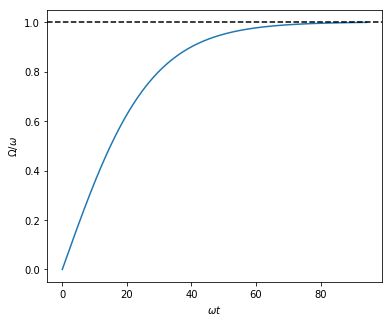

In [99]:
whirrMax = omega
steps = 150000
whirrtime = 150000
times = np.arange(steps)
Omega = [rotation_freq_simple(t, whirrTime=whirrtime) for t in times]

plt.figure(figsize=(6,5))
plt.plot(omega*dt*times, np.array(Omega)/omega)
plt.axhline(Omega[-1]/omega,ls='--',c='k')
plt.xlabel(r'$\omega t$')
plt.ylabel(r'$\Omega/\omega$')
plt.show()

In [100]:
hallstrip = deepcopy(groundstate)

In [101]:
hallenv = hallstrip.env
hallenv.rotating_frame(omegaR=Omega)
hallenv.absorbing_boundaries(strength=1, radius=1.2*e.fov/2)

hallstrip.evolve(dt=dt, steps=steps, cooling=0.0)

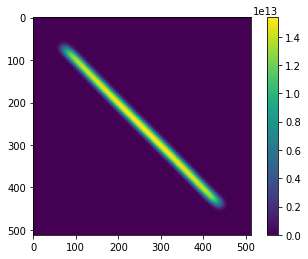

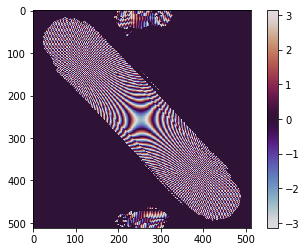

In [102]:
hallstrip.show_density()
hallstrip.show_phase()

In [103]:
startstrip = deepcopy(hallstrip)

In [104]:
steps=2000
startstrip.env.rotating_frame(omegaR=omega*np.ones(steps))
# startstrip.env.harmonic_potential(omega=omega, epsilon=0.05)
startstrip.evolve(steps=steps, cooling=0.0, dt=2e-5)

## Make Rotini

In [105]:
rotini = deepcopy(startstrip)

In [106]:
rotini.env.harmonic_potential(omega=omega, epsilon=0.0)
rotini.env.rotating_frame(omegaR=[omega]*10000)
# rotini.env.absorbing_boundaries(strength=1, radius=1*e.fov/2)
# rotini.env.spoon['type'] = 'mouse'

In [107]:
noise = (0.j)*np.zeros((DIM,DIM))
for i in range(DIM):
    for j in range(DIM):
        noise[i,j]= np.exp(0.15 * 1.j * 2*np.pi * (0.5-np.random.rand()))

In [108]:
rotini.Psi *= noise

In [109]:
rotini.evolve(steps=10000, cooling=0.0, dt=5e-5)

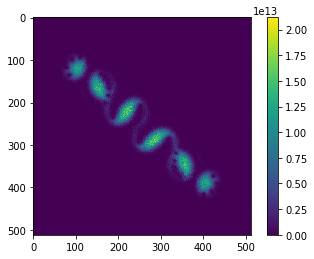

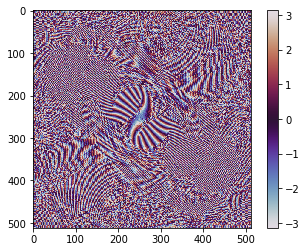

In [111]:
rotini.show_density()
rotini.show_phase()

In [251]:

dt = 1e-5
def compute_rotini(stripPsi, rotiniSteps=250000, frames=50, noise=0.15, randomTimes=False, 
                   dsname='rotini', datafile='data/rotini.hdf5'):
    
    steps = frames*(rotinisteps//frames)
    runtime = steps//frames
    times = np.arange(steps)
    Omega = omega* np.ones(runtime)
    x = stripPsi.copy() * noise if usenoise else stripPsi.copy()
    vmax = np.max(np.abs(x))**2
    out = []
    density = np.fliplr(np.abs(x.copy())**2)
    density *= density>1
    out.append(density)
    
    for i in tqdm(range(frames), leave=False):
        gpcore.Setup(DIM, fov, g, dt, False, 0.00)
        gpcore.SetHarmonicPotential(omega,0) #omega, epsilon
        gpcore.RotatingFrame(Omega)
        gpcore.Evolve(x, runtime , 50, show, vmax)
        
        density = np.fliplr(np.abs(x.copy())**2)
        density *= density>1
        out.append(density)
        
    with h5py.File(datafile, 'a') as f:
        dset = f.create_dataset(dsname, data=np.array(out))
        dset.attrs['stripsteps'] = stripsteps
        dset.attrs['time'] = dt*runtime * np.arange(frames)
        dset.attrs['dt'] = dt

## Process Data

In [24]:
# Set some processing parameters
viewx = 350
viewy = 350
fov = 300e-6
dx = fov/512
mass = 3.8e-26
lb = np.sqrt(hbar / (2*mass *omega))
x  = dx * (np.arange(viewx) - viewx//2)
y  = dx * (np.arange(viewy) - viewy//2)
dt = 1e-5
times = np.arange(51)*dt*5e3



    
def process_r1d(dset):
    """ Process a dataset corresponding to a single squeeze time """
    clouds = np.array([rotate_crop(a, viewx, viewy, 42) for a in dset[()]])
    times = np.array(dset.attrs['time'])
    xprofile  =  np.sum(rotate_crop(clouds[0],viewy=150), axis=0)
    xprofilemax = np.max(xprofile)
    gaussfit,_ = curve_fit(gauss, x, xprofile, [0, xprofilemax, 6e-6])
    newresults = pd.DataFrame([[clouds, times, xprofile, gaussfit]],
                              columns=columns)
    return newresults




In [46]:
columns = ['cloud', 'time', 'xprofile', 'gaussfit']
gs = pd.DataFrame(columns=columns)

with h5py.File('data/geometricsqueezing.hdf5', 'r') as f:
    for name in tqdm(f):
        dset=f[name]
        alltimes =  np.array(dset.attrs['time'])
        for i in tqdm(range(len(dset)-1), leave=False):
            cloud = rotate_crop(np.fliplr(dset[i]), viewx, viewy, 42.2)
            xprofile  =  np.sum(rotate_crop(cloud, viewx=350, viewy=150), axis=0)
            xprofilemax = np.max(xprofile)
            gaussfit,_ = curve_fit(gauss, x, xprofile, [0, xprofilemax, 6e-6])
            newresults = pd.DataFrame([[cloud, alltimes[i], xprofile, gaussfit]], columns=columns)
            gs = gs.append(newresults)
            
        
        
    

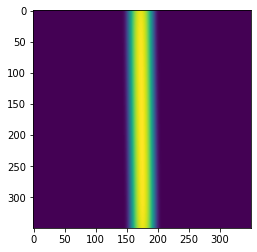

In [24]:
plt.imshow(gs.iloc[0].cloud)

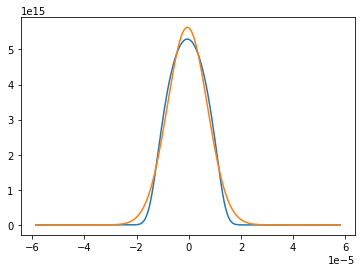

In [11]:
plt.plot(x,gs.iloc[0].xprofile)
plt.plot(x,gauss(x,*gs.iloc[0].gaussfit))

In [12]:
gs.head()

,cloud,time,xprofile,gaussfit
0,"[[2.7126095591907048e-11, -4.8243962259616635e...",0.000,"[9.32053512940961e-09, -4.1944736536293555e-08...","[-5.377215836858165e-07, 5633362403424438.0, 7..."
0,"[[-2.167784531647882e-12, 1.4503769748717715e-...",0.002,"[-2.5111884874582545e-10, -6.488398696351045e-...","[-5.768934624889789e-07, 5634538193729892.0, 7..."
0,"[[2.8597784904207056e-13, -2.3205898553101973e...",0.004,"[4.573862723064566e-12, 1.4403617961391765e-11...","[-5.858469240930829e-07, 5602642182199426.0, 7..."
0,"[[-4.608010310441162e-15, 3.2517888864800703e-...",0.006,"[-1.1023522712951248e-13, -2.1303718276767428e...","[-5.608554571660093e-07, 5525174654175018.0, 7..."
0,"[[1.8211601881375992e-17, 4.440056450750012e-1...",0.008,"[2.9156380635562312e-15, -1.0370908202275614e-...","[-5.038568694027151e-07, 5397949244664887.0, 7..."


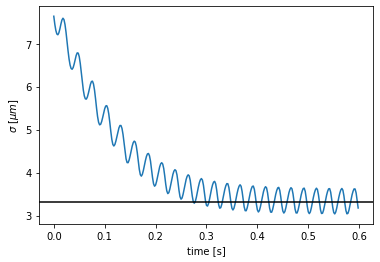

In [50]:
widths = np.array([abs(r[4][2]) for r in gs.itertuples()])
plt.plot(gs['time'], 1e6*widths)
plt.axhline(1e6*lb/np.sqrt(2),c='k')
plt.xlabel('time [s]')
plt.ylabel(r'$\sigma$ [$\mu m$]')
plt.savefig('figures/rotini1d/widths.png')


# Find vortices

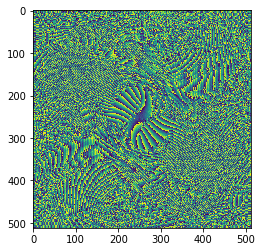

In [112]:
plt.imshow(rotini.phase)

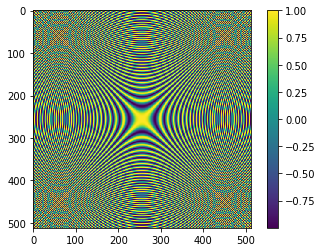

In [113]:
x = np.linspace(-5,5,DIM)
xx, yy = np.meshgrid(x, x)
 
# phase = xx * yy
phase = (xx + yy)*(xx- yy)
# phase = np.arctan(yy/xx)

plt.imshow(np.exp(9j * phase).real)
plt.colorbar()

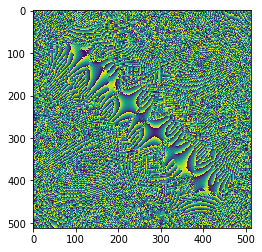

In [114]:
test = rotini.Psi * np.exp(14j * phase)
plt.imshow(np.angle(test))

In [115]:
vorts = np.zeros((DIM,DIM))

for i in range(DIM-1):
    for j in range(DIM-1):
        g = np.zeros(4)
        dphi = np.zeros(4)
        g[0] = (test[i,j]     / test[i+1,j])   * (np.abs(test[i+1, j])   / np.abs(test[i,j]))
        g[1] = (test[i+1,j]   / test[i+1,j+1]) * (np.abs(test[i+1, j+1]) / np.abs(test[i+1,j]))
        g[2] = (test[i+1,j+1] / test[i,j+1])   * (np.abs(test[i, j+1])   / np.abs(test[i+1,j+1]))
        g[3] = (test[i,j+1]   / test[i,j])     * (np.abs(test[i, j])     / np.abs(test[i,j+1]))
        for k in range(4):
            dphi[k] = np.angle(g[k])
            if dphi[k] <= -np.pi:
                dphi[k] += 2 * np.pi
        total = sum(dphi)
        
        vorts[i,j] = total

/home/biswaroop/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys
/home/biswaroop/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  
/home/biswaroop/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':
/home/biswaroop/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


In [127]:
np.shape(something.flatten())

(262144,)

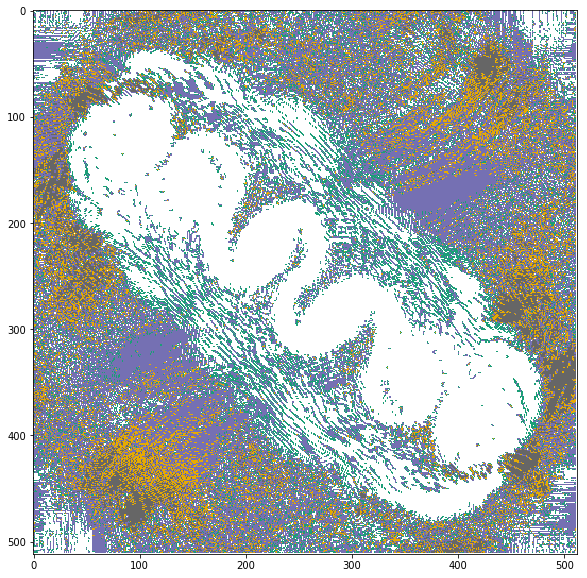

In [134]:
plt.figure(figsize=(10,10))
something = np.round(vorts/ (np.pi))
something[something==0] = np.nan
plt.imshow(something, cmap='Dark2')

In [135]:
from skimage.filters import gaussian as gaussblur

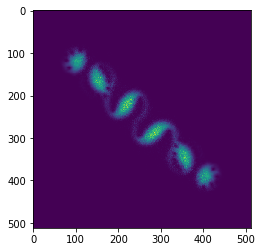

In [137]:
plt.imshow(rotini.density)

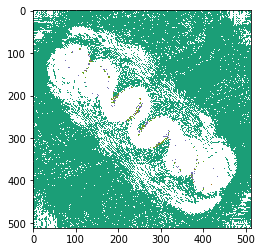

In [163]:
blurred = gaussblur(rotini.density, sigma=10) / 1e13


plt.imshow(something * (blurred>.1), cmap='Dark2')

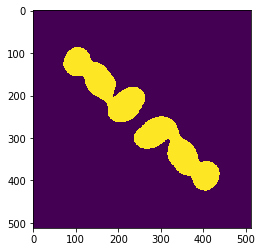

In [162]:
plt.imshow(blurred>0.1)

# Data for ML

To run this section, reproduce the ground state and the hall strip from above. Use a 30000 ramp and a 10Hz trap

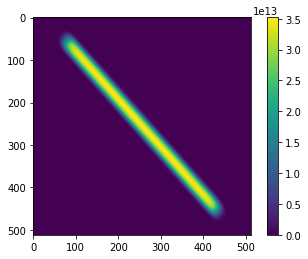

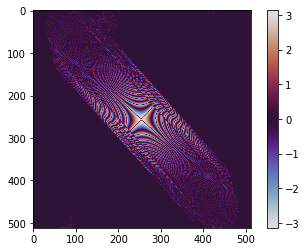

In [60]:
hallstrip.show_density()
hallstrip.show_phase()

In [61]:
# Set run parameters    
dt = 5e-5
noiseReps = 10
rotiniMLrun = pd.DataFrame()
rotiniMLrun['squeezeTime'] = [2000,3500, 5000,6500 ,8000, 10000,15000]
rotiniMLrun['runTime'] = [12000,14000, 15000 ,15000, 15000, 20000, 30000]

In [62]:
def runtimeFinder(runTime, numFrames, random=True):
    times = []
    basetime = runTime // numFrames
    times = [basetime] * numFrames
    if random: times = [t + int(np.random.normal(scale=basetime/10)) for t in times]
    return times


def noiseMaker(amp=0.15):
    noise = (0.j)*np.zeros((DIM,DIM))
    for i in range(DIM):
        for j in range(DIM):
            noise[i,j]= np.exp(amp * 1.j * 2*np.pi * (0.5-np.random.rand()))
    return noise


def compute_rotini_ML(startStrip, runTime=10000,
                   frames=7, noise=0.15, 
                   dsname='rotini', datafile='data/rotiniML.hdf5'):
    
    rotini = deepcopy(startStrip)
    rotini.env.harmonic_potential(omega=omega, epsilon=0.0)
    out = []
    out.append(rotini.Psi.copy())
    times = runtimeFinder(runTime, frames)
    
    for steps in tqdm(times, leave=False):
        rotini.env.rotating_frame(omegaR=[omega]*steps)
        rotini.evolve(steps=steps, cooling=0.0, dt=dt)
        out.append(rotini.Psi.copy())
                
    with h5py.File(datafile, 'a') as f:
        dset = f.create_dataset(dsname, data=np.array(out))
        dset.attrs['times'] = times
        dset.attrs['dt'] = dt

In [63]:
for i, r in tqdm(rotiniMLrun.iterrows(), leave=True):
    squeezeStrip = deepcopy(hallstrip)
    steps = r.squeezeTime
    squeezeStrip.env.rotating_frame(omegaR=omega*np.ones(steps))
    squeezeStrip.evolve(steps=steps, cooling=0.0, dt=2e-5) 
    
    for i in tqdm(range(noiseReps), leave=False):
        startStrip = deepcopy(squeezeStrip)
        startStrip.Psi *= noiseMaker()
        compute_rotini_ML(startStrip=startStrip, runTime=r.runTime, frames=10,
                          dsname=f'rotini_{steps}_{i}')
    

## rotate and clean

In [5]:

def clean_rotini(img):


In [149]:

viewx=356
viewy=356
with h5py.File('data/rotiniML.hdf5', 'r') as f:
    names = [name for name in f]
    print(names[20])
    dset = f[names[20]]
    clouds = dset[()]
#     for name in tqdm(f):
#         dset=f[name]
#         clouds = dset[()]
# #         clouds = [rotate_crop(a, viewx, viewy, 42) for a in dset[()]]
#         break

rotini_2000_0


In [150]:
rotini = clouds[8]

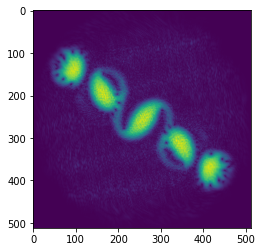

In [151]:
plt.imshow(np.abs(rotini))

In [161]:
def getimage(psi):
    psi = psi.copy()
    psi = psi[::2,::2]
    n = np.abs(psi)**2
    nimg = [255*n/n.max(),255*n/n.max(),255*n/n.max()]
    rg = np.array([np.real(psi), np.imag(psi),0*np.real(psi)])
    phiimg = 255*(rg+np.max(np.real(psi)))/(2.4*np.max(np.real(psi)))
    allimg = np.hstack([nimg,phiimg]).T
    return Image.fromarray(np.uint8(allimg))

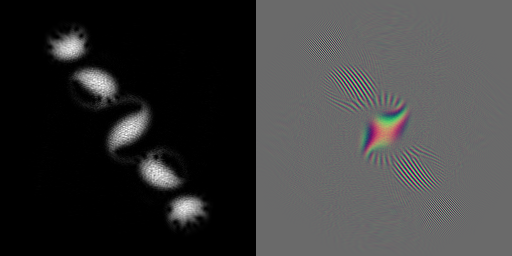

In [162]:
getimage(rotini* np.exp(13j * phase))
getimage(rotini)

In [105]:
with h5py.File('data/rotiniML.hdf5', 'r') as f:
#     names = [name for name in f]
#     print(names[20])
#     dset = f[names[20]]
    for name in tqdm(f):
        dset = f[name]
        for i in tqdm(range(len(dset)), leave=False):
            cloud = dset[i]
            im = getimage(cloud)
            im.save('data/rotiniML/'+name+str(i)+'.jpg')
    

        
            
        
        
    

In [128]:
imfake = Image.open('data/rotiniMLoutput/rotini_5000_30_fake_B.png')
imreal = Image.open('data/rotiniMLoutput/rotini_5000_30_real_B.png')
imn = Image.open('data/rotiniMLoutput/rotini_5000_30_real_A.png')

In [146]:
fakearray = np.array(imfake)
realarray = np.array(imreal)

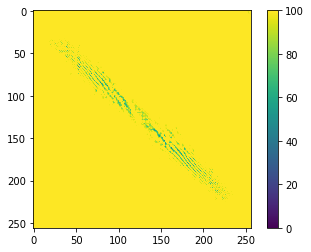

In [145]:
plt.imshow(fakearray[:,:,2], vmax=100, vmin=0)
plt.colorbar()

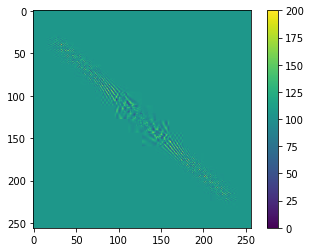

In [148]:
plt.imshow(realarray[:,:,2], vmax=200, vmin=0)
plt.colorbar()

In [153]:
imtest = getimage(rotini)

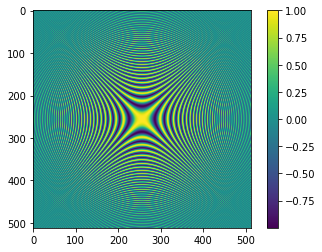

In [19]:
x = np.linspace(-5,5,DIM)
xx, yy = np.meshgrid(x, x)
 
# phase = xx * yy
phase = (xx + yy)*(xx- yy)
# phase = np.arctan(yy/xx)

plt.imshow(np.exp(9j * phase).real)
plt.colorbar()

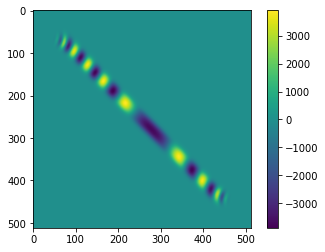

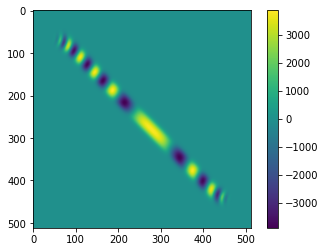

In [21]:
test= rotini.Psi * np.exp(14j * phase)
plt.figure()
plt.imshow(test.real)
plt.colorbar()
test2= rotini.Psi * np.exp(14j * phase) * np.exp(0j*phase + 3j)
plt.figure()
plt.imshow(test2.real)
plt.colorbar()

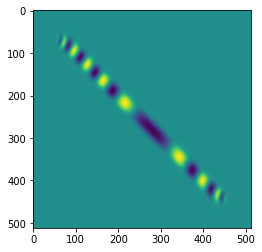

In [22]:
plt.imshow(test.real - test2.real)

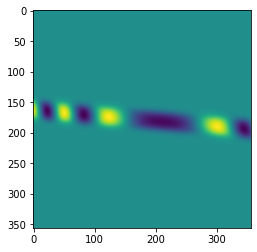

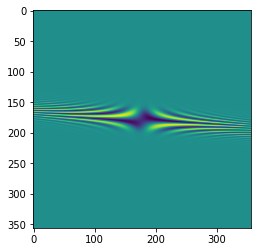

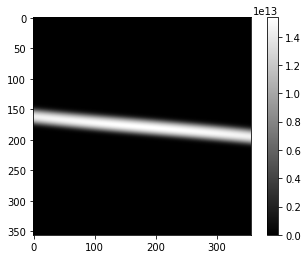

In [23]:
plt.imshow(rotate_crop(test.real, viewx=356, viewy=356, angle=40))
plt.show()
plt.imshow(rotate_crop(rotini.Psi.real, viewx=356, viewy=356, angle=40))
plt.show()
plt.imshow(rotate_crop(rotini.density, viewx=356, viewy=356, angle=40), cmap='gist_gray')
plt.colorbar()

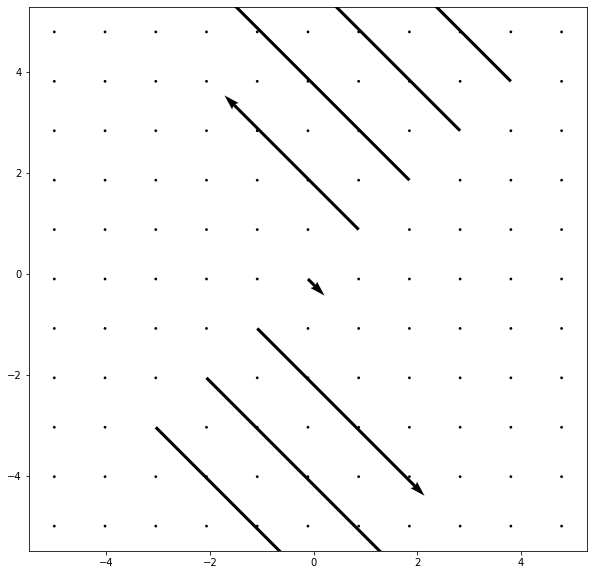

In [63]:
vx, vy = np.gradient(phase*(np.abs(test)>5e2))
skip=50
plt.figure(figsize=(10,10))
plt.quiver(xx[::skip,::skip],yy[::skip,::skip],vx[::skip,::skip],vy[::skip,::skip])

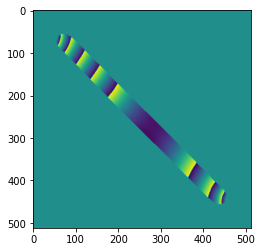

In [25]:
plt.imshow(np.angle(test)* (np.abs(test)>5e2))

In [42]:
alal = [np.linalg.norm([vxx,vyy]) for (vxx,vyy) in zip(vx.flatten(), vy.flatten())]

In [46]:
alal= (vy-vy2).flatten()

(0.0, 1000.0)

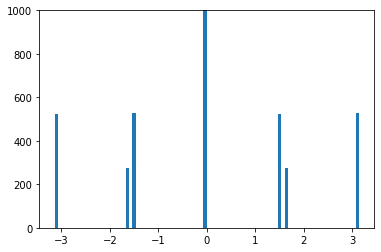

In [47]:
plt.hist(alal, bins=90)
plt.ylim([0,1000])

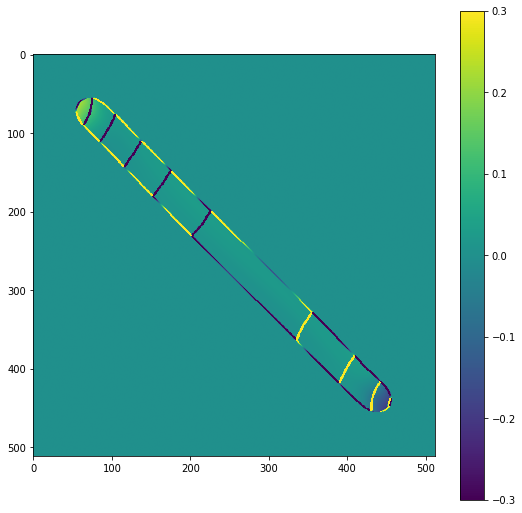

In [65]:
plt.figure(figsize=(9,9))
plt.imshow(vy-vy2, vmin=-.3,vmax=.3)
plt.colorbar()

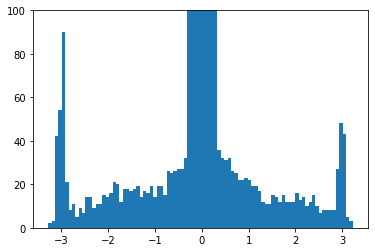

In [69]:
plt.hist((vx-vx2).flatten(), bins=90)
plt.ylim([0,100])
plt.show()

In [ ]:
vx2, vy2 = np.gradient(np.angle(test2)*(np.abs(test2)>5e2))

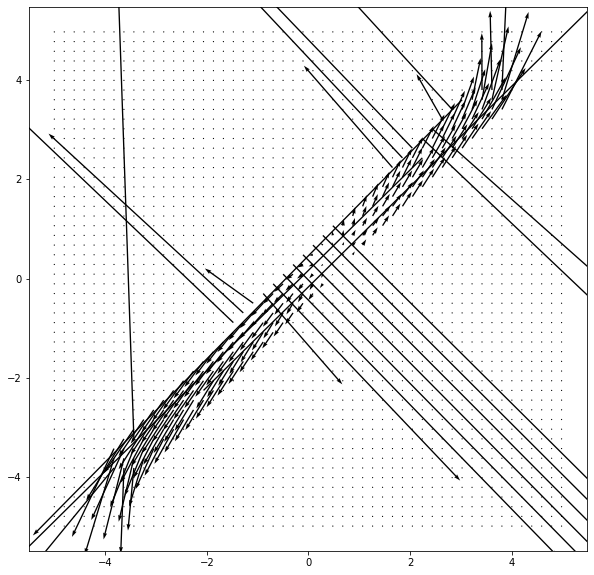

In [59]:
vx, vy = np.gradient(np.angle(test)*(np.abs(test)>5e2))
skip=10
plt.figure(figsize=(10,10))
plt.quiver(xx[::skip,::skip],yy[::skip,::skip],vx[::skip,::skip],vy[::skip,::skip])

# Reproducing lab parameters


            Running condensate on 512x512 grid with:
            atom number: 8e+05 
            mass:        3.80e-26
        


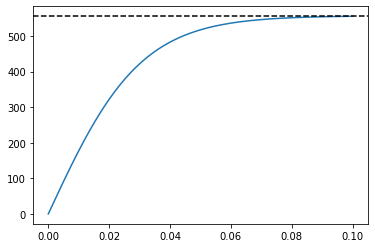

In [2]:
omega   = 2*np.pi*88.6
epsilon = 0.2
dt = 1e-6

e = Environment(DIM=512, fov=120e-6, N=8e5)
e.harmonic_potential(omega=omega, epsilon=epsilon)

groundstate = Wavefunction(e)
groundstate.initialize_Psi(width=100)
groundstate.relax(vmax=1e9, dt=2*dt, steps=4000)
groundstate.evolve(dt=dt, cooling=0.01, steps=4000)

whirrMax = omega
steps = 100000
whirrtime = 100000
times = np.arange(steps)
Omega = [np.min([whirrMax, omega * 1.001 * np.tanh(3.3 * t / whirrtime)]) for t in times]
plt.plot(dt*times, Omega)
plt.axhline(Omega[-1],ls='--',c='k')
plt.show()


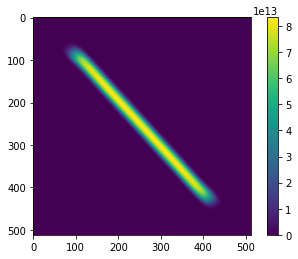

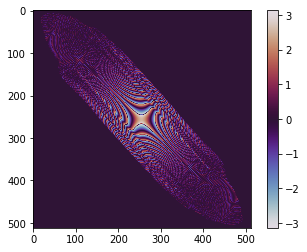

In [3]:
# Run the sim - takes longer than the 10Hz sim above
hallstrip = deepcopy(groundstate)
hallenv = hallstrip.env
hallenv.rotating_frame(omegaR=Omega)
hallenv.absorbing_boundaries(strength=1, radius=e.fov/2)

hallstrip.evolve(dt=dt, steps=steps, cooling=0)
hallstrip.show_density()
hallstrip.show_phase()

In [4]:
finalstrip = deepcopy(hallstrip)

## Crop and find the angle to the diagonal after the ramp

In [10]:
width = 512//2
plotrange=140
ncrop = finalstrip.density[(width-plotrange):(width+plotrange),(width-plotrange):(width+plotrange)]

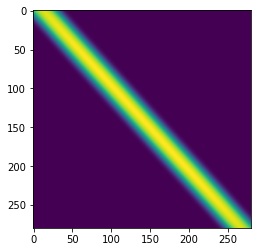

In [13]:
plt.imshow(ncrop)

In [20]:
xsize = len(ncrop)
xx = np.linspace(-10, 10, xsize)
yy = np.linspace(-10, 10, xsize)
xx, yy = np.meshgrid(xx, yy)

# Calculate the moment of inertia tensor
Ixx = np.sum(ncrop*yy*yy)
Iyy = np.sum(ncrop*xx*xx)
Ixy = np.sum(ncrop*xx*yy)
Iyx = Ixy
I =np.array( [[Ixx, Ixy], [Iyx, Iyy]])
evals, evecs = np.linalg.eig(I)
iangle = (180*np.arctan(evecs[np.argmin(evals)][1]/evecs[np.argmin(evals)][0])/np.pi)


In [21]:
print(f"angle from diagonal equipotential: {(iangle-45):.2f} degrees")

angle from diagonal equipotential: 2.47 degrees
